In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.metrics import R2Score
import yfinance as yf

/root/myCryptoBot/.venv/lib/python3.12/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
2024-12-31 01:25:25.445566: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-31 01:25:25.552471: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-31 01:25:25.659872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735619125.733889   25534 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN

In [43]:

def read_invest_com_crypto_data(ticker_name):
    try:
        # Read the CSV file
        ticker = yf.Ticker(ticker_name)
        df = ticker.history(period="max", interval="1d")
        print(df.head())

        # Set the timestamp as the index
        return df.loc[:, ~df.columns.isin(["Volume", "Dividends", "Stock Splits"])]
    
    except FileNotFoundError:
        print("Error: The specified CSV file was not found.")
        return None
    
    except pd.errors.EmptyDataError:
        print("Error: The CSV file is empty.")
        return None
    
    except pd.errors.ParserError:
        print("Error: An error occurred while parsing the CSV file.")
        return None

                               Open      High       Low     Close     Volume  \
Date                                                                           
2017-11-09 00:00:00+00:00  0.217911  0.221791  0.214866  0.217488  147916992   
2017-11-10 00:00:00+00:00  0.218256  0.219068  0.205260  0.206483  141032992   
2017-11-11 00:00:00+00:00  0.205948  0.214456  0.205459  0.210430  134503008   
2017-11-12 00:00:00+00:00  0.210214  0.210214  0.195389  0.197339  251175008   
2017-11-13 00:00:00+00:00  0.197472  0.204081  0.197456  0.203442  132567000   

                           Dividends  Stock Splits  
Date                                                
2017-11-09 00:00:00+00:00        0.0           0.0  
2017-11-10 00:00:00+00:00        0.0           0.0  
2017-11-11 00:00:00+00:00        0.0           0.0  
2017-11-12 00:00:00+00:00        0.0           0.0  
2017-11-13 00:00:00+00:00        0.0           0.0  


,Open,High,Low,Close
Date,,,,
2017-11-09 00:00:00+00:00,0.217911,0.221791,0.214866,0.217488
2017-11-10 00:00:00+00:00,0.218256,0.219068,0.205260,0.206483
2017-11-11 00:00:00+00:00,0.205948,0.214456,0.205459,0.210430
2017-11-12 00:00:00+00:00,0.210214,0.210214,0.195389,0.197339
2017-11-13 00:00:00+00:00,0.197472,0.204081,0.197456,0.203442
...,...,...,...,...
2024-12-27 00:00:00+00:00,2.154330,2.231316,2.123510,2.141650
2024-12-28 00:00:00+00:00,2.141667,2.199492,2.135006,2.180824
2024-12-29 00:00:00+00:00,2.180833,2.192813,2.071951,2.093180


In [44]:
# Fetch Ripple price data
df = read_invest_com_crypto_data("ETH-USD")
dataCutoff = int(len(df) * 0.3)
print("Cutoff: ", dataCutoff)

train_date_series = df.index[:-dataCutoff]
test_date_series = df.index[-dataCutoff:]

train_data = df["Close"][:-dataCutoff].values.reshape(-1, 1)
testData = df["Close"][-dataCutoff:].values.reshape(-1, 1)

print(f"Train Data: {train_data.shape}\nTest Data: {testData.shape}")

train_target = train_data
test_target = testData
print(f"Train Target: {train_target.shape}\nTest Data: {test_target.shape}")

                               Open      High       Low     Close     Volume  \
Date                                                                           
2017-11-09 00:00:00+00:00  0.217911  0.221791  0.214866  0.217488  147916992   
2017-11-10 00:00:00+00:00  0.218256  0.219068  0.205260  0.206483  141032992   
2017-11-11 00:00:00+00:00  0.205948  0.214456  0.205459  0.210430  134503008   
2017-11-12 00:00:00+00:00  0.210214  0.210214  0.195389  0.197339  251175008   
2017-11-13 00:00:00+00:00  0.197472  0.204081  0.197456  0.203442  132567000   

                           Dividends  Stock Splits  
Date                                                
2017-11-09 00:00:00+00:00        0.0           0.0  
2017-11-10 00:00:00+00:00        0.0           0.0  
2017-11-11 00:00:00+00:00        0.0           0.0  
2017-11-12 00:00:00+00:00        0.0           0.0  
2017-11-13 00:00:00+00:00        0.0           0.0  
Cutoff:  270
Train Data: (2340, 1)
Test Data: (270, 1)
Train Target:

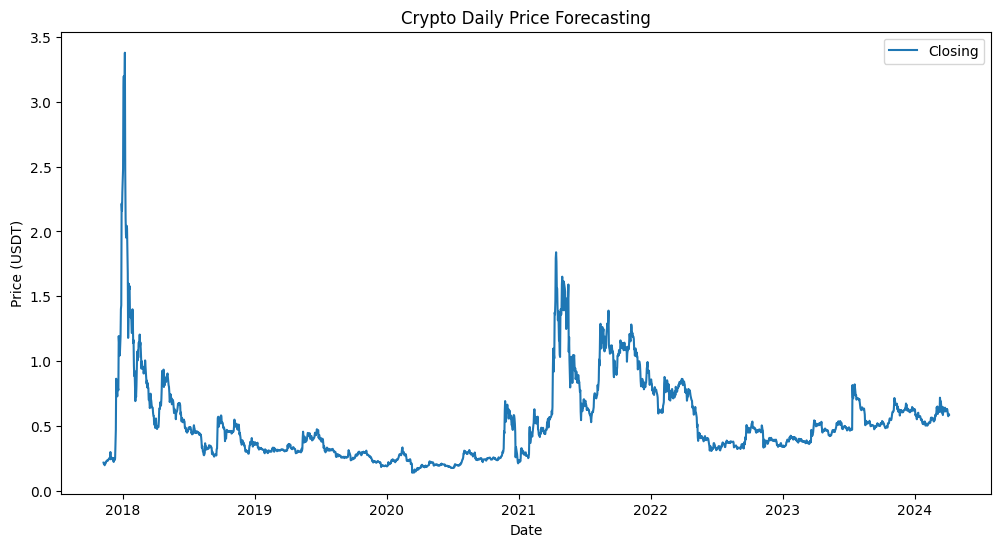

In [45]:
# Plot train data
plt.figure(figsize=(12, 6))
plt.plot(train_date_series, train_data, label='Closing')
plt.title('Crypto Daily Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.show()

### Normalization
- Scales the input data between (0, 1)
- I think MinMax only can be used also
- it's important to keep the scaling parameters!

In [46]:
# Normalize the data
scaler = RobustScaler()
normalized_data = scaler.fit_transform(train_data)
print(normalized_data.shape)


(2340, 1)


In [47]:
normalized_data

array([[-0.71938886],
       [-0.75357336],
       [-0.74131295],
       ...,
       [ 0.39088224],
       [ 0.44909059],
       [ 0.43003978]])

In [48]:
# Function to prepare data for LSTM
def prepare_data(normalized_data, target, data, seq_len):
    X, y = [], []
    for i in range(len(normalized_data) - seq_len):
        X.append(normalized_data[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y), data[:-seq_len]


In [49]:
# Prepare data for each EWT component
seq_len = 24  # 24 hours for daily predictions
X, y, train_data = prepare_data(normalized_data, train_target, train_data, seq_len)

y = y.reshape(-1, 1)
train_date_series= train_date_series[:-seq_len]
print(y.shape, X.shape, train_date_series.shape)

(2316, 1) (2316, 24, 1) (2316,)


In [50]:
# Create LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        Input(input_shape),
        LSTM(100, return_sequences=True),
        Dropout(0.3),
        LSTM(100),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


In [51]:
# Train separate LSTM models for each EWT component
model = create_lstm_model((seq_len, 1))
model.fit(X, y, epochs=100, verbose=2 )


Epoch 1/100
73/73 - 6s - 83ms/step - loss: 0.0412
Epoch 2/100
73/73 - 2s - 28ms/step - loss: 0.0080
Epoch 3/100
73/73 - 2s - 33ms/step - loss: 0.0069
Epoch 4/100
73/73 - 2s - 31ms/step - loss: 0.0058
Epoch 5/100
73/73 - 3s - 35ms/step - loss: 0.0048
Epoch 6/100
73/73 - 2s - 30ms/step - loss: 0.0054
Epoch 7/100
73/73 - 2s - 28ms/step - loss: 0.0045
Epoch 8/100
73/73 - 2s - 29ms/step - loss: 0.0047
Epoch 9/100
73/73 - 2s - 30ms/step - loss: 0.0048
Epoch 10/100
73/73 - 2s - 28ms/step - loss: 0.0046
Epoch 11/100
73/73 - 2s - 29ms/step - loss: 0.0043
Epoch 12/100
73/73 - 2s - 29ms/step - loss: 0.0045
Epoch 13/100
73/73 - 2s - 30ms/step - loss: 0.0039
Epoch 14/100
73/73 - 2s - 29ms/step - loss: 0.0042
Epoch 15/100
73/73 - 2s - 27ms/step - loss: 0.0040
Epoch 16/100
73/73 - 2s - 34ms/step - loss: 0.0041
Epoch 17/100
73/73 - 2s - 28ms/step - loss: 0.0040
Epoch 18/100
73/73 - 2s - 28ms/step - loss: 0.0038
Epoch 19/100
73/73 - 2s - 28ms/step - loss: 0.0038
Epoch 20/100
73/73 - 2s - 31ms/step - lo

In [52]:
# Make predictions
predictions = np.zeros_like(y)
for i in range(seq_len, len(y)):
    print(i)
    inputs = normalized_data[i-seq_len:i]
    print(inputs.shape)
    pred = model.predict(inputs.reshape(1, seq_len, 1 ))
    
    # Reshape the prediction to match the original data shape
    print(pred.shape)
    predictions[i] = pred


24
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
(1, 1)
25
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
(1, 1)
26
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
(1, 1)
27
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
(1, 1)
28
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
(1, 1)
29
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
(1, 1)
30
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
(1, 1)
31
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
(1, 1)
32
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(1, 1)
33
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
(1, 1)
34
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
(1, 1)
35
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
(1, 1)
36
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
(1, 1)
37
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
(1, 1)
38
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
(1, 1)
39
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
(1, 1)
40
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
(1, 1)
41
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
(

In [53]:
print(train_date_series.shape, train_data.shape, predictions.shape)

(2316,) (2316, 1) (2316, 1)


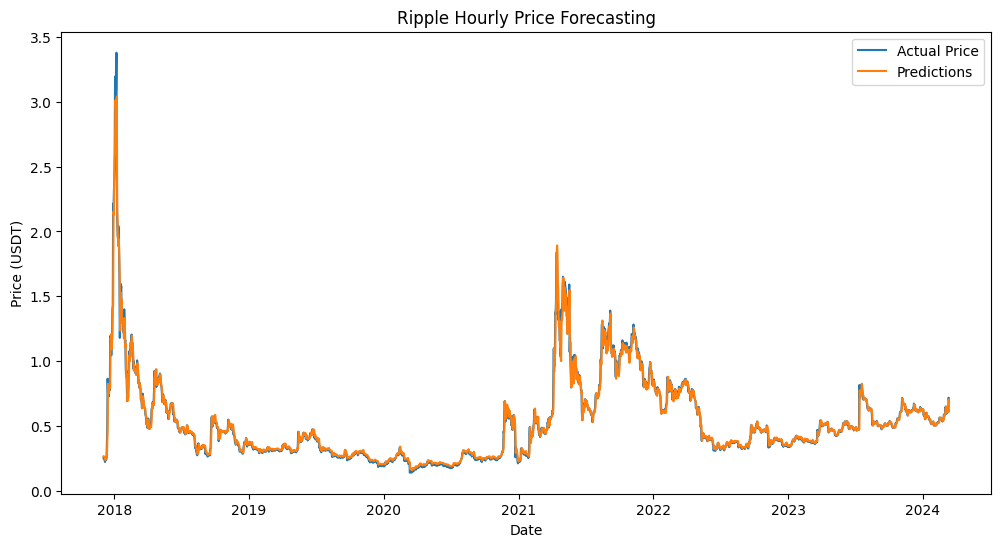

In [54]:
reshaped = predictions.reshape(-1, 1)
# Plot result
plt.figure(figsize=(12, 6))
plt.plot(train_date_series[seq_len:], train_data[seq_len:], label='Actual Price')
plt.plot(train_date_series[seq_len:], reshaped[seq_len:], label='Predictions')
plt.title('Ripple Hourly Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.show()


In [55]:
# Evaluate the model
mse = np.mean((train_data[seq_len:] - reshaped[seq_len:]) ** 2)
rmse = np.sqrt(mse)

mae = np.mean(np.abs(train_data[seq_len:] - reshaped[seq_len:]))
mape = np.mean(np.abs((train_data[seq_len:] - reshaped[seq_len:]) / train_data[seq_len:])) * 100
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")

RMSE: 0.0493
MAE: 0.0232
MAPE: 4.2083


In [56]:
normalized_test_data = scaler.transform(testData)
X_test, y_test, testData = prepare_data(normalized_test_data, test_target, testData, seq_len)
y_test = y_test.reshape(-1, 1)
y_test.shape
print(testData.shape)

(246, 1)


In [57]:
model.evaluate(X_test, y_test, verbose=2)

8/8 - 1s - 68ms/step - loss: 0.0062


0.006206077057868242

In [58]:
# Make test predictions
print(len(y_test) - 1)
test_predictions = np.zeros_like(y_test)
for i in range(seq_len, len(y_test)):
    print(i)
    inputs = normalized_test_data[i-seq_len:i]
    print(inputs.shape)
    pred = model.predict(inputs.reshape(1, seq_len, 1 ))
    
    # Reshape the prediction to match the original data shape
    print(pred.shape)
    test_predictions[i] = pred

245
24
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
(1, 1)
25
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(1, 1)
26
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
(1, 1)
27
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(1, 1)
28
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
(1, 1)
29
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(1, 1)
30
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
(1, 1)
31
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
(1, 1)
32
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
(1, 1)
33
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
(1, 1)
34
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
(1, 1)
35
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(1, 1)
36
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
(1, 1)
37
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
(1, 1)
38
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
(1, 1)
39
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
(1, 1)
40
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
(1, 1)
41
(24, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/

(270,) (246, 1) (246, 1)


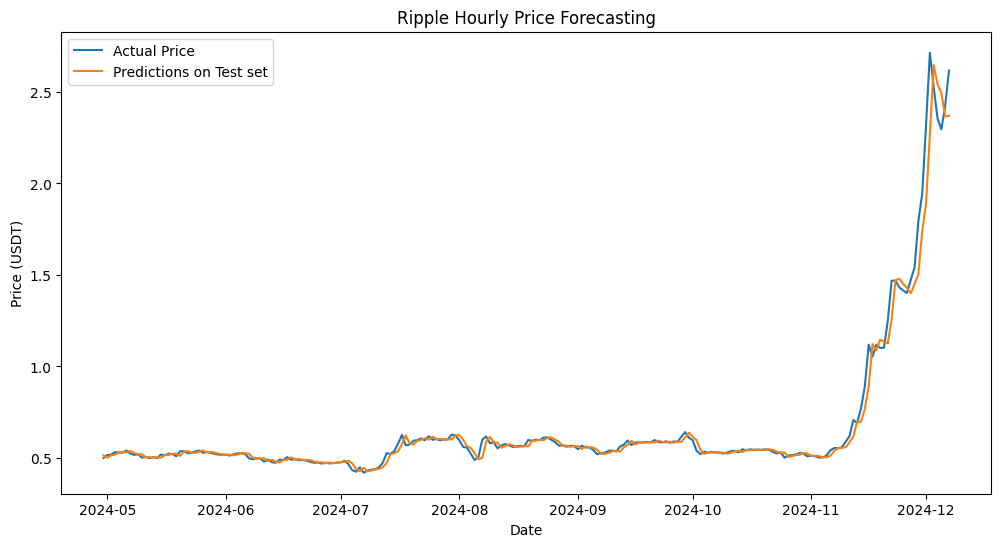

In [59]:
test_reshaped = test_predictions.reshape(-1, 1)
print(test_date_series.shape, testData.shape, test_reshaped.shape)
# Plot result
plt.figure(figsize=(12, 6))
plt.plot(test_date_series[seq_len:-seq_len], testData[seq_len:], label='Actual Price')
plt.plot(test_date_series[seq_len:-seq_len], test_reshaped[seq_len:], label='Predictions on Test set')
plt.title('Ripple Hourly Price Forecasting')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.show()

In [60]:
# Evaluate the model 
r2 = R2Score()
testDataToUse = testData[seq_len:]
testPredictionsToUse = test_reshaped[seq_len:]
print(testDataToUse.shape, testPredictionsToUse.shape)

r2.update_state(testDataToUse, testPredictionsToUse)
r2.result().numpy()

mse = np.mean((testDataToUse - testPredictionsToUse) ** 2)
rmse = np.sqrt(mse)

mae = np.mean(np.abs(testDataToUse - testPredictionsToUse))
mape = np.mean(np.abs((testDataToUse - testPredictionsToUse) / testDataToUse)) * 100
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"accuracy: {r2.result().numpy()}")

(222, 1) (222, 1)
RMSE: 0.0635
MAE: 0.0259
MAPE: 2.8146
accuracy: 0.9744855165481567
